In [27]:
import yfinance as yf 
import pandas as pd
import numpy as np
from datetime import datetime

import quandl

import sys
import urllib

import ezodf
from matplotlib import pylab as plt 

In [28]:
def import_MSCI(name):
    '''Function to clean data from MSCI
    https://www.msci.com/end-of-day-data-country
    '''
    
    
    path = "Data/" + name + ".xls"
    imp_tmp = pd.read_excel(path)
    price_type = imp_tmp.loc[1][1]
    
    imp = imp_tmp[6:]
    imp.columns = ['Date', name]
    #imp['Date'] = pd.to_datetime(imp['Date'], errors='coerce')
    imp.loc[0] = pd.to_datetime(imp['Date'], errors='coerce')
    imp = imp.dropna()
    
    imp = imp.set_index('Date')
    #imp.index = imp.index.strftime('%Y/%m')
    
    print(price_type)
    
    return(imp)

In [29]:
def Import_bond_return(filename, sheet_no=0, header=0):
    '''10 YEAR BOND RETURN. sheet1:Original US, sheet2: Improved US, sheet3:germany, 
    sheet4:Japan, sheet5:Australia, sheet6:Norway. sheet7:Sweden'''
    
    tab = ezodf.opendoc(filename=filename).sheets[sheet_no]
    temp_data= pd.DataFrame({col[header].value:[x.value for x in col[header+1:]]
                         for col in tab.columns()})
    temp_data['observation_date'] = pd.to_datetime(temp_data['observation_date'], errors='coerce')
    temp_data.index = temp_data['observation_date']
    bond_ret = pd.DataFrame(temp_data['Cum Ret'])
    bond_ret = bond_ret.dropna()
    bond_ret.columns = ['10Y Bond']
    return(bond_ret)

# Data Collection

## Equity

### Monthly

In [30]:
USA = import_MSCI("USA")
Pacific_ex_Japan = import_MSCI("PACIFIC_ex_JAPAN")
Japan = import_MSCI("JAPAN")
Sweden = import_MSCI("SWEDEN")
Emerging_Markets = import_MSCI("EMERGING_MARKETS")
RUSSIA = import_MSCI("RUSSIA")

Gross
Gross
Gross
Gross
Gross
Gross


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [31]:
#Emerging_Markets


### Daily

In [21]:
SP500_daily_tmp = yf.download("^SP500TR")
SP500_daily= pd.DataFrame(SP500_daily_tmp['Close'])
SP500_daily.columns = ['SP500']

[*********************100%***********************]  1 of 1 completed


## Bonds

### Yearly

In [32]:
# Only says T-bond, 10 yr?, 30 yr?
d = pd.read_html('http://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/histretSP.html')
T_tmp = d[0]
T_tmp = pd.DataFrame(T_tmp[7][:])

years =  pd.Series(range(1926,2020))
T_tmp.insert(0, "Year", years, True)
T_tmp.insert(2, "Month", 1, True)
T_tmp.insert(3, "Day", 1, True)
T_tmp = T_tmp[2:]
T_tmp.columns = ['Year','T bond', 'Month', 'Day'] 
T_tmp['T bond'] = T_tmp['T bond'].str.replace('$', '')
T_tmp['T bond'] = T_tmp['T bond'].str.replace(',', '')
T_tmp['T bond'] = pd.to_numeric(T_tmp['T bond'])

T_tmp['Year'] = pd.to_datetime(T_tmp['Year']*10000+T_tmp['Month']*100+T_tmp['Day'],format='%Y%m%d')
T_tmp = T_tmp.set_index('Year')
T_bond_yearly = pd.DataFrame(T_tmp['T bond'])
#T_bond_yearly

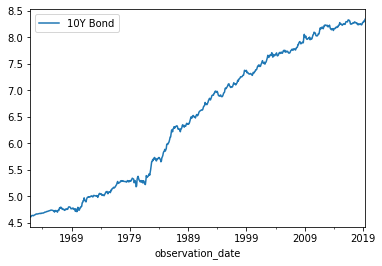

In [50]:
path = 'Data/International Monthly Government Bond Returns.ods'
bond_import = bond_return(filename=path, sheet_no = 1)

np.log(bond_import).plot();

In [108]:
(bond_import.tail(1)/100)**(12/(len(bond_import))) -1 

,10Y Bond
observation_date,
2019-05-31,0.067044


In [142]:
#Attemp to calculate bond return from YTM. 30YR
TYX_tmp = yf.download('^FVX') #data import
TYX_tmp = TYX_tmp['Adj Close']


[*********************100%***********************]  1 of 1 completed


In [143]:
TYX_monthly = TYX_tmp.resample('M').last()/100


In [128]:
TLT_tmp = yf.download('ISTB') #data import
TLT_tmp = TLT_tmp['Adj Close']
TLT_monthly_tmp = TLT_tmp.resample('M').last()

[*********************100%***********************]  1 of 1 completed


In [144]:
TLT_monthly = (TLT_monthly_tmp.pct_change()+1).cumprod()
TLT_monthly = pd.DataFrame(TLT_monthly)

In [145]:
def calc_bond_returns(YTM, YTMM1, M):
    DY = YTM - YTMM1
    yield_income = (1+YTM)**(1/12) - 1
    Z = (1+(YTM/2))
    

    duration = (1/YTM)* (1 -(1/(1+0.5*YTM)**(2*M)))


    C1 = (2/YTM**2) * (1-Z**(-2*M))
    C2 = ((2*M)/YTM) * Z **(-2*M - 1) 
    convex = C1-C2

    ret = yield_income - duration* DY + (1/2)*convex * (DY**2)
    return(ret)
    

In [146]:
def monthly_bonds_ret(bond_YTM, M):
    bond_ret = [0]

   
    
    for i in range(len(TYX_monthly)-1):
        YTM = bond_YTM[i+1]
        YTMM1 = bond_YTM[i]
        
        ret = calc_bond_returns(YTM, YTMM1, M)
        bond_ret.append(ret)

    bond_ret = pd.DataFrame(bond_ret)
    bond_ret.index = TYX_monthly.index
    
    return(bond_ret)
    


In [147]:
calc_ret = monthly_bonds_ret(TYX_monthly, 5)
formula = (calc_ret+1).cumprod()

bond_diff = pd.concat([formula, TLT_monthly], axis = 1)
bond_diff = bond_diff.dropna()
bond_diff.columns = ['Formula', 'TLT']

bond_diff = bond_diff/bond_diff.iloc[0] #normalize

bond_diff.plot()

## Alternatives

In [8]:
#Gold
Gold_tmp = quandl.get("LBMA/GOLD", authtoken="6rNSyTM5R4g7_B7XSyQW")
Gold = pd.DataFrame(Gold_tmp["USD (AM)"])


,USD (AM)
Date,
1968-01-02,35.18
1968-01-03,35.16
1968-01-04,35.14
1968-01-05,35.14
1968-01-08,35.14
...,...
2020-07-16,1804.60
2020-07-17,1802.90
2020-07-20,1810.30


In [ ]:
#Long Vol(Monthly)
long_vol_imp = pd.read_excel (r'https://www.eurekahedge.com/Indices/ExportIndexReturnsToExcel?IndexType=Eurekahedge&IndexId=640')

long_vol = long_vol_imp[3:]
long_vol.index= pd.to_datetime(long_vol_imp[3:]['Unnamed: 0'])
long_vol = pd.DataFrame(long_vol['Unnamed: 2'])
long_vol.columns = ["Long Vol"]